In [1]:
import enlighten
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from os.path import join, exists
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, train_test_split
from sklearn.mixture import BayesianGaussianMixture
from sklearn.linear_model import LinearRegression

In [2]:
sns.set(style='whitegrid', context='paper')
plt.rcParams["font.family"] = "monospace"
plt.rcParams['font.monospace'] = 'Courier New'

In [3]:
PROJ_DIR = "/Volumes/projects_herting/LABDOCS/Personnel/Katie/deltaABCD_clustering/"
DATA_DIR = "data/"
FIGS_DIR = "figures/"
OUTP_DIR = "output/"

In [4]:
imputed_cdk = pd.read_csv(join(join(PROJ_DIR, DATA_DIR, "desikankillany_MICEimputed_data.csv")), 
                          index_col='subjectkey', 
                          header=0)
imputed_dcg = pd.read_csv(join(join(PROJ_DIR, DATA_DIR, "destrieux+gordon_MICEimputed_data.csv")), 
                          index_col='subjectkey', 
                          header=0)

In [5]:
n_iter = 10
max_k = 10
k_split = 10
labels = {}
index = pd.MultiIndex.from_product((range(0,n_iter), range(0, k_split)))
log_likelihood = pd.DataFrame(index=index, 
                              columns=range(2,max_k))

In [6]:
atlases = {'desikankillany': imputed_cdk,
           'destrieux+gordon': imputed_dcg}

In [7]:
parameter_grid = {
    'weight_concentration_prior_type': [
        'dirichlet_process', 
        'dirichlet_distribution'],
    'weight_concentration_prior': [
        10**-1,
        10**0,
        10**1, 
        10**2, 
        10**3, 
    ],
    'n_components': list(range(2,11)),
    'covariance_type': [
        'full',
        'tied',
        'diag', 
        'spherical']
}

estimator = BayesianGaussianMixture(
    max_iter=1000
)

In [12]:
# hyper parameter tuning
iterations = 5
manager = enlighten.get_manager()
tocks = manager.counter(total=iterations * len(atlases.keys()), 
                        desc='Number of Iterations', 
                        unit='iter')
max_comp = {}
for atlas in atlases.keys():
    big_results = pd.DataFrame()
    best_params = pd.DataFrame()
    n_comps = 0
    for i in range(0,iterations):
        data = atlases[atlas]
        all_subj = data.index.to_list()
        for id_ in data['rel_family_id']:
            siblings = data[data['rel_family_id'] == id_].index.to_list()
            if len(siblings) > 1:
                keep = np.random.choice(siblings)
                siblings.remove(keep)
                all_subj = list(set(all_subj) - set(siblings))
            else:
                pass
        data = data.loc[all_subj]
        data.drop('rel_family_id', axis=1, inplace=True)

        # need train test split
        search = HalvingGridSearchCV(estimator, 
                                    parameter_grid, 
                                    factor=2, 
                                    cv=10, 
                                    n_jobs=-1).fit(data)
        parameters = pd.Series(search.best_estimator_.get_params(), name=i)
        parameters['test_score'] = search.best_estimator_.score(data)
        labels = search.best_estimator_.predict(data)
        for k in range(0, parameters['n_components']):
            print(np.sum(labels == k))
            parameters.loc[k] = np.sum(labels == k)
            if np.max(labels) > n_comps:
                n_comps = np.max(labels)
        nonzero_components = np.sum(parameters.loc[list(range(0, parameters['n_components']))] != 0)
        parameters.loc['n_components_nonzero'] = nonzero_components
        
        results = pd.DataFrame.from_dict(search.cv_results_)
        results["params_str"] = results.params.apply(str)
        
        big_results = pd.concat([big_results, results], axis=0)
        big_results.to_csv(join(PROJ_DIR, 
                            OUTP_DIR, 
                            f'bgmm_{atlas}_cv-results.csv'))
        best_params = pd.concat([best_params, parameters], axis=1)
        best_params.to_csv(join(PROJ_DIR,
                                OUTP_DIR,
                                f'bgmm_{atlas}_best-models.csv'))
        tocks.update()
    max_comp[atlas] = n_comps
    #labels = search.best_estimator_.fit(data)
    #labels_df = pd.Series(labels, index=data.index)
    #labels_df.to_csv(join(PROJ_DIR, 
    #                    OUTP_DIR, 
    #                    f'bgmm_{atlas}_bestimator-labels.csv'))

44
5712
0
0
76
190
0
2768
3232
22
0
0
0
211
1
0
25
0
0
5763
0
5695
284
23
0
24
205
1
5779
0
60
23
5962
5928
80
0
0
0
0
0
5999
23
103
5912
0
100
5893


In [76]:
gdn_indices = range(0, max_comp['destrieux+gordon'])
gdn_indices = [str(i) for i in gdn_indices]

cdk_indices = range(0, max_comp['desikankillany'])
cdk_indices = [str(i) for i in cdk_indices]

['0', '1', '2', '3', '4', '5', '6', '7', '8']


In [72]:
cdk_models = pd.read_csv(join(PROJ_DIR, 
                            OUTP_DIR, 
                            f'bgmm_desikankillany_best-models.csv'), 
                     index_col=0, 
                     header=0)
gdn_models = pd.read_csv(join(PROJ_DIR, 
                            OUTP_DIR, 
                            f'bgmm_destrieux+gordon_best-models.csv'), 
                     index_col=0, 
                     header=0)
cdk_models = cdk_models.T
gdn_models = gdn_models.T
#change datatype of test_score
cdk_models['test_score'] = cdk_models['test_score'].astype(float)
gdn_models['test_score'] = gdn_models['test_score'].astype(float)
cdk_models['n_components'] = cdk_models['n_components'].astype(int)
gdn_models['n_components'] = gdn_models['n_components'].astype(int)
cdk_models['n_components_nonzero'] = cdk_models['n_components'].astype(int)
gdn_models['n_components_nonzero'] = gdn_models['n_components'].astype(int)

nonzero_components = np.sum(cdk_models[cdk_indices].fillna(0).astype(int) > 1, axis=1)
cdk_models['n_components_nonzero'] = nonzero_components

nonzero_components = np.sum(gdn_models[gdn_indices].fillna(0).astype(int) > 1, axis=1)
gdn_models['n_components_nonzero'] = nonzero_components

cdk_models['weight_concentration_prior'] = cdk_models['weight_concentration_prior'].astype(float)
gdn_models['weight_concentration_prior'] = gdn_models['weight_concentration_prior'].astype(float)

/var/folders/t5/4bz0680d45n5_5m30ny85m540000gp/T/ipykernel_2271/1195983771.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1][0].set_yticklabels(ylabels)
/var/folders/t5/4bz0680d45n5_5m30ny85m540000gp/T/ipykernel_2271/1195983771.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2][0].set_yticklabels(ylabels)
/var/folders/t5/4bz0680d45n5_5m30ny85m540000gp/T/ipykernel_2271/1195983771.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1][1].set_yticklabels(ylabels)
/var/folders/t5/4bz0680d45n5_5m30ny85m540000gp/T/ipykernel_2271/1195983771.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2][1].set_yticklabels(ylabels)


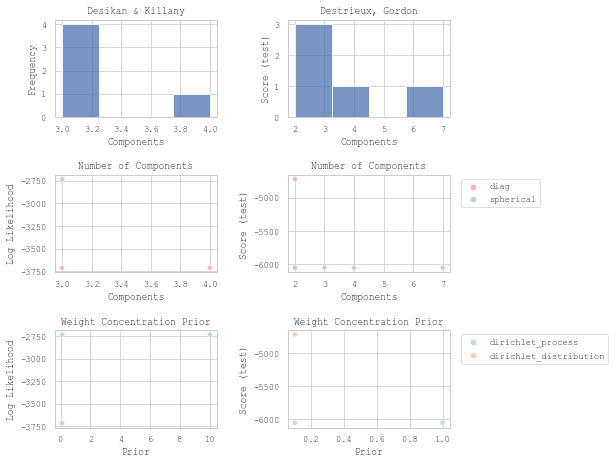

In [74]:
fig,ax = plt.subplots(nrows=3, ncols=2, figsize=(7,7))
plt.tight_layout(pad=4)
#how often was each # components the best option
sns.histplot(x='n_components_nonzero',
              data=cdk_models.sort_values('n_components'), 
              ax=ax[0][0])
ax[0][0].set_title(f'Desikan & Killany')
ax[0][0].set_xlabel('Components')
ax[0][0].set_ylabel('Frequency')

#what were the scores of each # components, does it depend on covariance type?
sns.scatterplot(x='n_components_nonzero',
              y='test_score',
              hue='covariance_type',
              data=cdk_models.sort_values('n_components'),
                palette='Pastel1', 
              ax=ax[1][0])
ax[1][0].set_title(f'Number of Components')
ax[1][0].set_xlabel('Components')
ax[1][0].set_ylabel('Log Likelihood')
ylabels = [f'{int(y)}' for y in ax[1][0].get_yticks()]
ax[1][0].set_yticklabels(ylabels)
ax[1][0].get_legend().remove()

#what weight concentration prior settings had best scores
sns.scatterplot(x='weight_concentration_prior',
              y='test_score',
              hue='weight_concentration_prior_type',
              data=cdk_models,
                palette='Pastel2',
              ax=ax[2][0])
ax[2][0].set_title(f'Weight Concentration Prior')
ax[2][0].set_xlabel('Prior')
ax[2][0].set_ylabel('Log Likelihood')
ylabels = [f'{int(y)}' for y in ax[2][0].get_yticks()]
ax[2][0].set_yticklabels(ylabels)
ax[2][0].get_legend().remove()

sns.histplot(x='n_components',
              
              data=gdn_models.sort_values('n_components'), 
              ax=ax[0][1])
ax[0][1].set_title(f'Destrieux, Gordon')
ax[0][1].set_xlabel('Components')
ax[0][1].set_ylabel('Score (test)')
sns.scatterplot(x='n_components',
              y='test_score',
              hue='covariance_type',
                palette='Pastel1',
              data=gdn_models.sort_values('n_components'), 
              ax=ax[1][1])
ax[1][1].set_title(f'Number of Components')
ax[1][1].set_xlabel('Components')
ax[1][1].set_ylabel('Score (test)')
ylabels = [f'{int(y)}' for y in ax[1][1].get_yticks()]
ax[1][1].set_yticklabels(ylabels)
ax[1][1].legend(bbox_to_anchor=(1.04,1), loc="upper left")
sns.scatterplot(x='weight_concentration_prior',
              y='test_score',
              hue='weight_concentration_prior_type',
              data=gdn_models, 
                palette='Pastel2',
              ax=ax[2][1])
ax[2][1].set_title(f'Weight Concentration Prior')
ax[2][1].set_xlabel('Prior')
ax[2][1].set_ylabel('Score (test)')
ylabels = [f'{int(y)}' for y in ax[2][1].get_yticks()]
ax[2][1].set_yticklabels(ylabels)
ax[2][1].legend(bbox_to_anchor=(1.04,1), loc="upper left")

fig.savefig(join('../', FIGS_DIR, f'bgmm_best-models.png'),
            dpi=500, bbox_inches='tight')

# outdated
# parameter iterating here is replaced by halving grid search above
# yay hyperparameter tuning

for atlas in atlases.keys():
    manager = enlighten.get_manager()
    tocks = manager.counter(total=max_k-2, 
                            desc='Number of Components', 
                            unit='k')

    for k in range(2,max_k+1):
        ticks = manager.counter(total=n_iter * k_split, desc='Iterations', unit='iters')
        for i in range(0,n_iter):
            # should be doing k-folds cv instead of split-half
            # need to adress this in the prereg, too
            data = atlases[atlas]
            all_ppts = list(data.index)
            kf = KFold(n_splits=k_split)
            lls = []
            j = 0
            for train, test in kf.split(all_ppts):
                train_df = data.iloc[train]
                test_df = data.iloc[test]
                bgmm = BayesianGaussianMixture(n_components=k,
                                               weight_concentration_prior_type='dirichlet_process',
                                               weight_concentration_prior=10**4,
                                               max_iter=1000).fit(train_df)
                log_likelihood.at[(i,j),k] = bgmm.score(test_df)
                if bgmm.converged_ == False:
                    print(k, f'iteration {i}', 'did not converge')
                ticks.update()
                j += 1

        ticks.close()
        tocks.update()
        #label = bgmm.predict(imputed_cdk)
        #labels[k] = pd.Series(label, index=imputed_cdk.index)
    ll_long = log_likelihood.melt(value_vars=list(range(2,max_k+1)), 
                              value_name='Log Likelihood', 
                              var_name='k')
    ll_long['k'] = ll_long['k'] - 2
    fig,ax = plt.subplots(figsize=(10,7))
    sns.lineplot(x='k', 
                 y='Log Likelihood', 
                 data=ll_long, 
                 ax=ax)
    sns.stripplot(data=log_likelihood, dodge=True, ax=ax)
    plt.tight_layout()
    fig.savefig(f'../figures/gmm_{atlas}_loglikelihood.png', dpi=400)
    

ll_long = log_likelihood.melt(value_vars=[2,3,4,5,6,7,8,9], 
                          value_name='Log Likelihood', 
                          var_name='k')
ll_long['k'] = ll_long['k'] - 2
fig,ax = plt.subplots(figsize=(10,7))
sns.lineplot(x='k', 
             y='Log Likelihood', 
             data=ll_long, 
             ax=ax)
sns.stripplot(data=log_likelihood, dodge=True, ax=ax)
plt.tight_layout()
fig.savefig(f'../figures/gmm_{atlas}_loglikelihood.png', dpi=400)